In [1]:
%load_ext autotime

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from keras.applications.densenet import DenseNet169
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import optimizers
from keras import metrics
from keras import models
from keras.utils import plot_model, multi_gpu_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras_tqdm import TQDMNotebookCallback
from ipywidgets import IntProgress, HTML, HBox


from pathlib import Path
import pickle

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


time: 1.1 s


In [3]:
import logging

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

time: 668 µs


In [4]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

time: 1.35 s


In [5]:
import utils # importing from our utils functions

time: 3.75 s


In [6]:
x_train, y_train, x_test, y_test = utils.read_mura_pickle()
x_train = utils.normalize_pixels(x_train)
x_test = utils.normalize_pixels(x_test)

INFO:utils.utils:loading data/MURA-v1.1/x_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_valid.pkl


time: 6.28 s


In [7]:
x_train.shape

(36808, 256, 256)

time: 3.16 ms


In [8]:
size = x_train.shape[1]
x_train = x_train.reshape(x_train.shape[0], size, size, 1)
x_test = x_test.reshape(x_test.shape[0], size, size, 1)

time: 1.73 ms


# Train Submodel

In [9]:
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[0.8, 1.2],
    fill_mode = 'constant',
    cval=0,
    horizontal_flip=True,
    vertical_flip=True)

time: 1.96 ms


In [10]:
datagen.fit(x_train)

time: 4.13 s


In [11]:
with open('trained_models/3_6_densenet169_no_top_inv.pkl', 'rb') as pkl:
    weights = pickle.load(pkl)

time: 62.9 ms


In [12]:
with tf.device('/CPU:0'):
    densenet = DenseNet169(input_shape=(256, 256, 1), classes=1, weights=None, include_top=False)
    densenet.set_weights(weights)
    model = models.Model(input=densenet.input, output=layers.Dense(1, activation='sigmoid')(layers.Flatten()(densenet.output)))

time: 20.3 s


In [13]:
model = multi_gpu_model(model, gpus=4)

time: 1min 7s


In [ ]:
clr_history = {'lr': [], 'loss': [], 'binary_accuracy': []}
train_history = {'loss': [], 'binary_accuracy': []}
val_per_image_history = {'accuracy': [], 'kappa': [], 'precision': [], 'recall': []}
val_per_study_history = {'accuracy': [], 'kappa': [], 'precision': [], 'recall': []}

In [32]:
starting_epoch = 140
train_round = 0
batch_size = 96
epochs_per_eval = 10
epochs_per_save = 10
total_epochs = 390
optimizer = 'adam'
base_lr = 5e-6
max_lr = 5e-5
model_name='5_0_base_layers'

time: 2.92 ms


In [33]:
def weighted_binary_crossentropy(p1):
    '''
    p1 is the proportion of ones in population
    '''
    w0 = K.variable(p1)
        
    def loss(y_true, y_pred):
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = -(1 - w0) * y_true * K.log(y_pred) - w0 * (1 - y_true) * K.log(1 - y_pred)
        loss = K.sum(loss, -1)
        return loss
    
    return loss

time: 4.67 ms


In [34]:
clr = utils.clr.CyclicLR(mode='triangular2', base_lr=base_lr, max_lr=max_lr)

time: 1.87 ms


In [35]:
p1 = y_train.mean()

time: 3.06 ms


In [ ]:
with tf.device('/CPU:0'):
    model = models.load_model(f'./trained_models/{model_name}_{starting_epoch}.h5')

In [18]:
progress = TQDMNotebookCallback(leave_inner=True, leave_outer=True) 

time: 1.18 ms


INFO:__main__:executing epochs 1-10


INFO:utils.mura_metrics:Accuracy: 0.7913669064748201
INFO:utils.mura_metrics:Kappa: 0.576955574561218
INFO:utils.mura_metrics:Precision: 0.8962350780532599
INFO:utils.mura_metrics:Recall: 0.6379084967320261


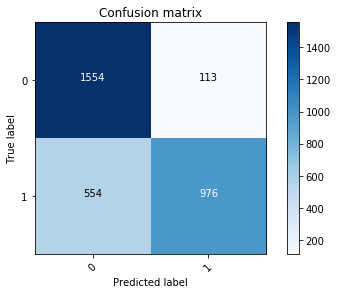

INFO:utils.mura_metrics:Accuracy: 0.7931609674728941
INFO:utils.mura_metrics:Kappa: 0.5683356318501851
INFO:utils.mura_metrics:Precision: 0.9073033707865169
INFO:utils.mura_metrics:Recall: 0.6003717472118959


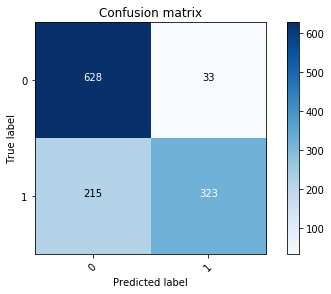

INFO:__main__:Saving Model to trained_models/5_0_base_layers_10.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 11-20


INFO:utils.mura_metrics:Accuracy: 0.8142008132624335
INFO:utils.mura_metrics:Kappa: 0.6247347083313243
INFO:utils.mura_metrics:Precision: 0.8792544570502431
INFO:utils.mura_metrics:Recall: 0.7091503267973857


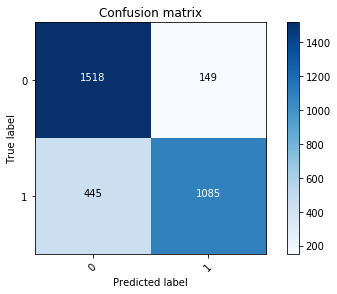

INFO:utils.mura_metrics:Accuracy: 0.8206839032527106
INFO:utils.mura_metrics:Kappa: 0.6298070088015704
INFO:utils.mura_metrics:Precision: 0.8872901678657075
INFO:utils.mura_metrics:Recall: 0.6877323420074349


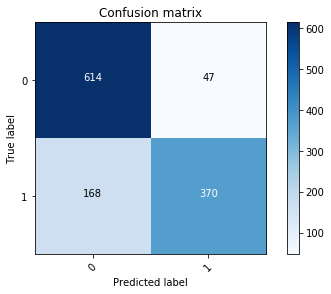

INFO:__main__:Saving Model to trained_models/5_0_base_layers_20.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 21-30


INFO:utils.mura_metrics:Accuracy: 0.8163903659680951
INFO:utils.mura_metrics:Kappa: 0.6296683443661563
INFO:utils.mura_metrics:Precision: 0.8669260700389105
INFO:utils.mura_metrics:Recall: 0.7281045751633987


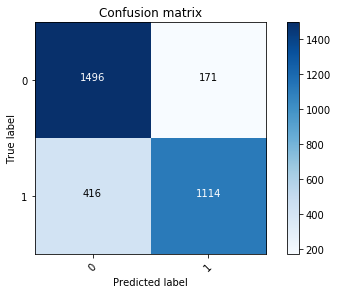

INFO:utils.mura_metrics:Accuracy: 0.823185988323603
INFO:utils.mura_metrics:Kappa: 0.6350369574831006
INFO:utils.mura_metrics:Precision: 0.8899521531100478
INFO:utils.mura_metrics:Recall: 0.6914498141263941


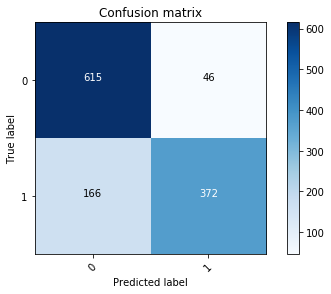

INFO:__main__:Saving Model to trained_models/5_0_base_layers_30.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 31-40


INFO:utils.mura_metrics:Accuracy: 0.8135752267751016
INFO:utils.mura_metrics:Kappa: 0.62385814799768
INFO:utils.mura_metrics:Precision: 0.8671383647798742
INFO:utils.mura_metrics:Recall: 0.7209150326797386


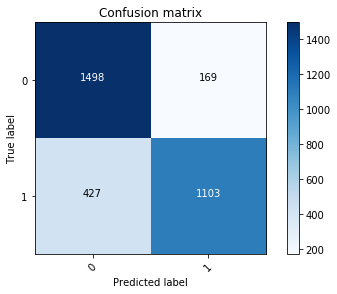

INFO:utils.mura_metrics:Accuracy: 0.8140116763969975
INFO:utils.mura_metrics:Kappa: 0.6163034821229971
INFO:utils.mura_metrics:Precision: 0.8741092636579573
INFO:utils.mura_metrics:Recall: 0.6840148698884758


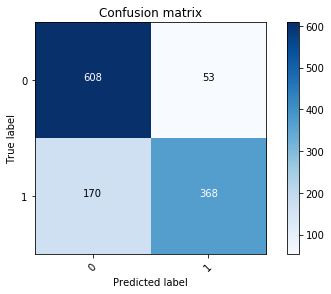

INFO:__main__:Saving Model to trained_models/5_0_base_layers_40.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 41-50


INFO:utils.mura_metrics:Accuracy: 0.8145136065060995
INFO:utils.mura_metrics:Kappa: 0.6263476946176177
INFO:utils.mura_metrics:Precision: 0.8519909842223892
INFO:utils.mura_metrics:Recall: 0.7411764705882353


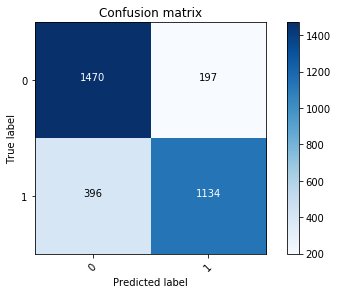

INFO:utils.mura_metrics:Accuracy: 0.8198498748957465
INFO:utils.mura_metrics:Kappa: 0.628806402696838
INFO:utils.mura_metrics:Precision: 0.8761682242990654
INFO:utils.mura_metrics:Recall: 0.6970260223048327


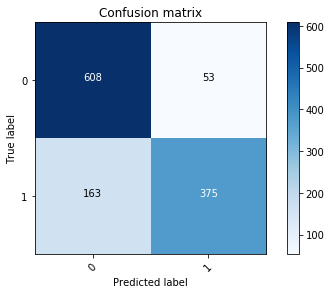

INFO:__main__:Saving Model to trained_models/5_0_base_layers_50.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 51-60


INFO:utils.mura_metrics:Accuracy: 0.8026274632467939
INFO:utils.mura_metrics:Kappa: 0.601780050617759
INFO:utils.mura_metrics:Precision: 0.8531029065200314
INFO:utils.mura_metrics:Recall: 0.7098039215686275


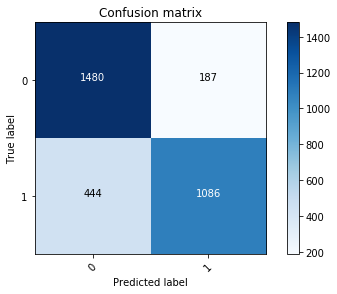

INFO:utils.mura_metrics:Accuracy: 0.8065054211843202
INFO:utils.mura_metrics:Kappa: 0.600606481773959
INFO:utils.mura_metrics:Precision: 0.8660287081339713
INFO:utils.mura_metrics:Recall: 0.6728624535315985


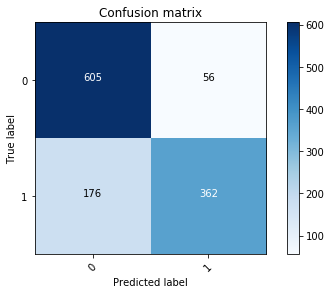

INFO:__main__:Saving Model to trained_models/5_0_base_layers_60.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 61-70


INFO:utils.mura_metrics:Accuracy: 0.7982483578354708
INFO:utils.mura_metrics:Kappa: 0.5935822310764982
INFO:utils.mura_metrics:Precision: 0.8324567993989481
INFO:utils.mura_metrics:Recall: 0.7241830065359477


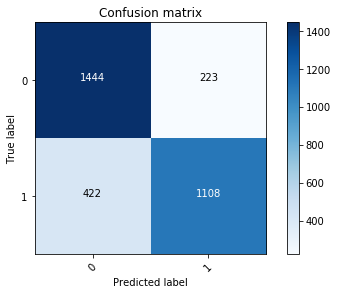

INFO:utils.mura_metrics:Accuracy: 0.8031693077564637
INFO:utils.mura_metrics:Kappa: 0.5944366251687673
INFO:utils.mura_metrics:Precision: 0.852803738317757
INFO:utils.mura_metrics:Recall: 0.6784386617100372


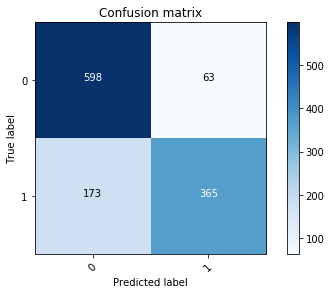

INFO:__main__:Saving Model to trained_models/5_0_base_layers_70.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 71-80


INFO:utils.mura_metrics:Accuracy: 0.7969971848608071
INFO:utils.mura_metrics:Kappa: 0.5914589375328949
INFO:utils.mura_metrics:Precision: 0.8222384784198976
INFO:utils.mura_metrics:Recall: 0.734640522875817


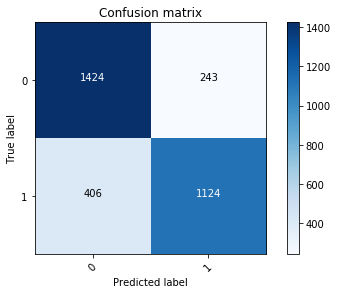

INFO:utils.mura_metrics:Accuracy: 0.798999165971643
INFO:utils.mura_metrics:Kappa: 0.5865002511401476
INFO:utils.mura_metrics:Precision: 0.8398169336384439
INFO:utils.mura_metrics:Recall: 0.6821561338289963


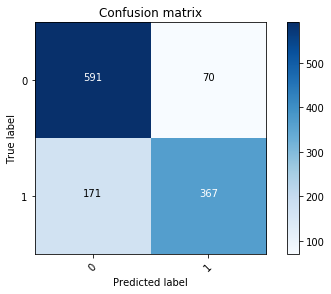

INFO:__main__:Saving Model to trained_models/5_0_base_layers_80.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 81-90


INFO:utils.mura_metrics:Accuracy: 0.7913669064748201
INFO:utils.mura_metrics:Kappa: 0.5798560547235577
INFO:utils.mura_metrics:Precision: 0.8212956068503351
INFO:utils.mura_metrics:Recall: 0.7209150326797386


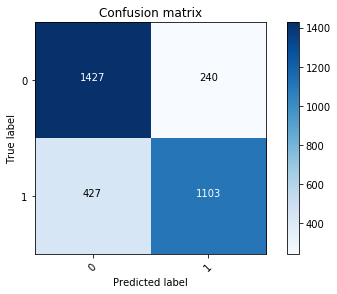

INFO:utils.mura_metrics:Accuracy: 0.7956630525437864
INFO:utils.mura_metrics:Kappa: 0.5783011459964771
INFO:utils.mura_metrics:Precision: 0.8496420047732697
INFO:utils.mura_metrics:Recall: 0.6617100371747212


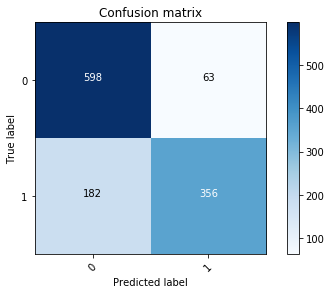

INFO:__main__:Saving Model to trained_models/5_0_base_layers_90.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 91-100


INFO:utils.mura_metrics:Accuracy: 0.7966843916171411
INFO:utils.mura_metrics:Kappa: 0.5903985259432336
INFO:utils.mura_metrics:Precision: 0.8313253012048193
INFO:utils.mura_metrics:Recall: 0.7215686274509804


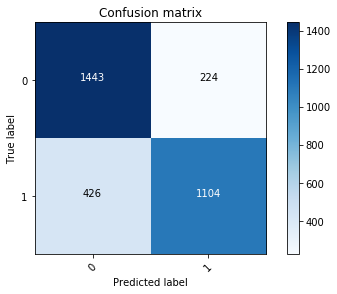

INFO:utils.mura_metrics:Accuracy: 0.8006672226855713
INFO:utils.mura_metrics:Kappa: 0.5887736871183693
INFO:utils.mura_metrics:Precision: 0.8551068883610451
INFO:utils.mura_metrics:Recall: 0.6691449814126395


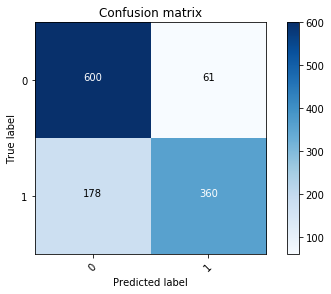

INFO:__main__:Saving Model to trained_models/5_0_base_layers_100.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 101-110


INFO:utils.mura_metrics:Accuracy: 0.802314670003128
INFO:utils.mura_metrics:Kappa: 0.6015261292240021
INFO:utils.mura_metrics:Precision: 0.8432721712538226
INFO:utils.mura_metrics:Recall: 0.7209150326797386


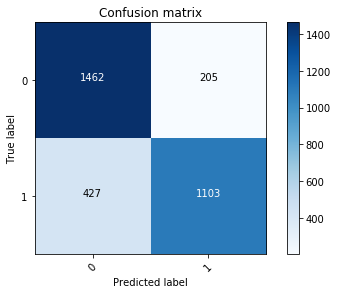

INFO:utils.mura_metrics:Accuracy: 0.8065054211843202
INFO:utils.mura_metrics:Kappa: 0.6007475004377643
INFO:utils.mura_metrics:Precision: 0.8642857142857143
INFO:utils.mura_metrics:Recall: 0.6747211895910781


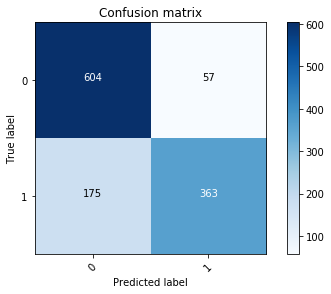

INFO:__main__:Saving Model to trained_models/5_0_base_layers_110.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 111-120


INFO:utils.mura_metrics:Accuracy: 0.7888645605254927
INFO:utils.mura_metrics:Kappa: 0.5754128115454425
INFO:utils.mura_metrics:Precision: 0.8064516129032258
INFO:utils.mura_metrics:Recall: 0.7352941176470589


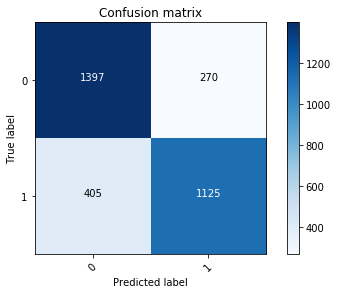

INFO:utils.mura_metrics:Accuracy: 0.7998331943286072
INFO:utils.mura_metrics:Kappa: 0.587998465159698
INFO:utils.mura_metrics:Precision: 0.8433179723502304
INFO:utils.mura_metrics:Recall: 0.6802973977695167


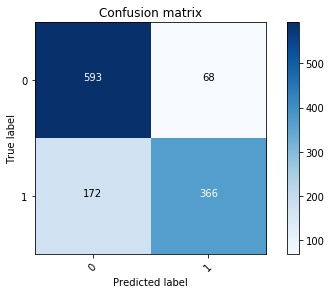

INFO:__main__:Saving Model to trained_models/5_0_base_layers_120.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 121-130


INFO:utils.mura_metrics:Accuracy: 0.7938692524241476
INFO:utils.mura_metrics:Kappa: 0.585096852674558
INFO:utils.mura_metrics:Precision: 0.8199853049228508
INFO:utils.mura_metrics:Recall: 0.7294117647058823


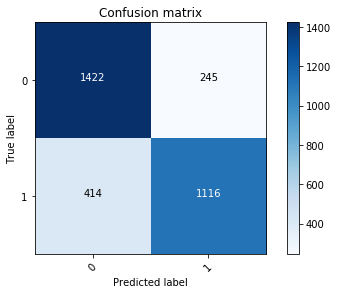

INFO:utils.mura_metrics:Accuracy: 0.7998331943286072
INFO:utils.mura_metrics:Kappa: 0.5881435257410297
INFO:utils.mura_metrics:Precision: 0.841743119266055
INFO:utils.mura_metrics:Recall: 0.6821561338289963


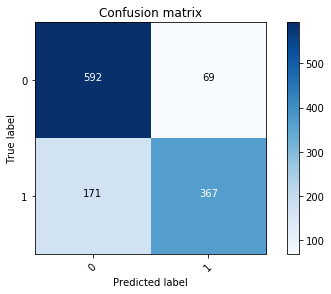

INFO:__main__:Saving Model to trained_models/5_0_base_layers_130.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 131-140


INFO:utils.mura_metrics:Accuracy: 0.7913669064748201
INFO:utils.mura_metrics:Kappa: 0.5797426148953366
INFO:utils.mura_metrics:Precision: 0.8237059264816204
INFO:utils.mura_metrics:Recall: 0.7176470588235294


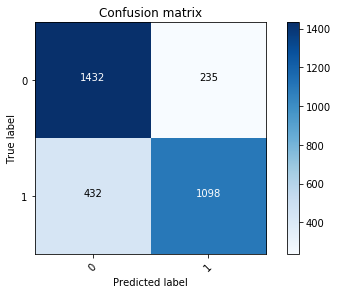

INFO:utils.mura_metrics:Accuracy: 0.7998331943286072
INFO:utils.mura_metrics:Kappa: 0.5865422193613647
INFO:utils.mura_metrics:Precision: 0.8599033816425121
INFO:utils.mura_metrics:Recall: 0.6617100371747212


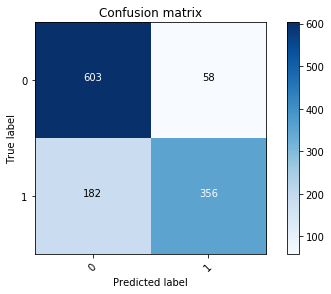

INFO:__main__:Saving Model to trained_models/5_0_base_layers_140.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 141-150


ResourceExhaustedError: OOM when allocating tensor with shape[24,8,8,1664] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_15/Adam/gradients/zeros_4-0-1-TransposeNCHWToNHWC-LayoutOptimizer = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_15/Adam/gradients/zeros_4, PermConstNCHWToNHWC-LayoutOptimizer)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: training_15/Adam/gradients/dense_1_1/concat_grad/Slice_1/_711353 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:1", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_109944_training_15/Adam/gradients/dense_1_1/concat_grad/Slice_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:1"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


time: 8h 23min 30s


In [20]:
while (train_round+1) * epochs_per_eval + starting_epoch <= total_epochs:
    log.info(f'executing epochs {train_round * epochs_per_eval + 1 + starting_epoch}-{(train_round+1) * epochs_per_eval + starting_epoch}')
    
    curr_round = train_round * epochs_per_eval + 1 + starting_epoch
#     if curr_round >= 10:
#         if np.min(train_history['loss'][-10:-5]) <= np.min(train_history['loss'][-5:]): # if no improvements in 10 epochs
#             if optimizer == 'adam':
#                 log.info(f'switching to SGD with lr={lr}')
#                 optimizer = 'sgd'
#             else:
#                 log.info(f'reducing SGD learn rate from {lr} to {lr * 0.8}')
#                 lr = lr * 0.5
#             opt = optimizers.SGD(lr=lr, momentum=0.9, nesterov=True)
#         else:
#             if optimizer == 'adam':
#                 opt = optimizers.Adam(lr=lr, amsgrad=True)
#             else:
#                 opt = optimizers.SGD(lr=lr, momentum=0.9, nesterov=True)
#     else:
#         opt = optimizers.Adam(lr=lr, amsgrad=True)
    if curr_round >= 10:
        if np.min(train_history['loss'][-10:-5]) <= np.min(train_history['loss'][-5:]): # if no improvements in 10 epochs
            base_lr = 0.5 * base_lr
            max_lr = 0.8 * max_lr
            clr_history['lr'].extend(clr.history['lr'])
            clr_history['loss'].extend(clr.history['loss'])
            clr_history['binary_accuracy'].extend(clr.history['binary_accuracy'])
            clr = utils.clr.CyclicLR(mode='triangular2', base_lr=base_lr, max_lr=max_lr)
    
    model.compile(
        loss=weighted_binary_crossentropy(p1),
        optimizer=opt,
        metrics=[metrics.binary_accuracy])
    
#     if train_round * epochs_per_eval + 1 + starting_epoch < 40:
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
                           steps_per_epoch = int(np.round(len(x_train) / batch_size)), 
                           epochs=epochs_per_eval, verbose=0,
                           callbacks=[clr, progress])
#     else:
#         model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                                steps_per_epoch = int(np.round(len(x_train) / batch_size)), 
#                                epochs=epochs_per_eval, verbose=0,
#                                callbacks=[progress])
        
    
    train_history['loss'].extend(model.history.history['loss'])
    train_history['binary_accuracy'].extend(model.history.history['binary_accuracy'])
    
    y_valid_hat = model.predict(x_test)
    true_label = np.round(y_test)
    pred_label = np.round(y_valid_hat)
    evaluate = utils.MURAMetrics(true_label, pred_label)
    
    per_image_metrics = evaluate.report_by_image()
    for key in per_image_metrics:
        val_per_image_history[key].append(per_image_metrics[key])
    
    per_study_metrics = evaluate.report_by_study()
    for key in per_image_metrics:
        val_per_study_history[key].append(per_study_metrics[key])
    
    cur_epoch = (train_round + 1) * epochs_per_eval
    if cur_epoch % epochs_per_save == 0:
        log.info(f'Saving Model to trained_models/{model_name}_{cur_epoch + starting_epoch}.h5...')
        model.layers[-2].save(f'./trained_models/{model_name}_{cur_epoch + starting_epoch}.h5')
    weighted_binary_crossentropy(p1)
    log.info('Saving evaluation metrics history...')
    with open(f'./trained_models/{model_name}_clr_history.pkl', 'wb') as pkl_file:
        pickle.dump(clr_history, pkl_file)
    with open(f'./trained_models/{model_name}_train_history.pkl', 'wb') as pkl_file:
        pickle.dump(train_history, pkl_file)
    with open(f'./trained_models/{model_name}_val_per_image_history.pkl', 'wb') as pkl_file:
        pickle.dump(val_per_image_history, pkl_file)'
    with open(f'./trained_models/{model_name}_val_per_study_history.pkl', 'wb') as pkl_file:
        pickle.dump(val_per_study_history, pkl_file)
    
    train_round += 1

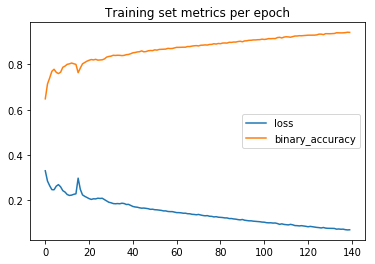

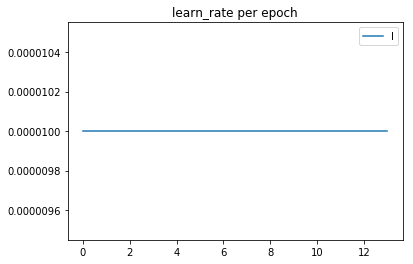

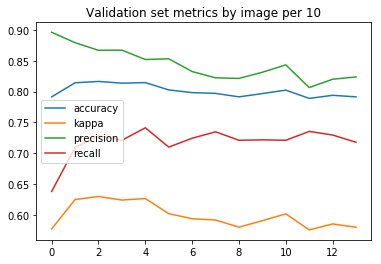

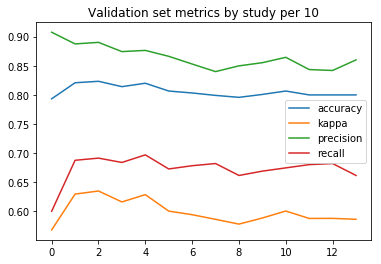

time: 543 ms


In [21]:
# 0 - 140: adam with lr=1e-5
# first 40 is clr with max=1e-4

train_metrics = ['loss', 'binary_accuracy']
validation_metrics = ['accuracy', 'kappa', 'precision', 'recall']

for metric in train_metrics:
    plt.plot(train_history[metric])
plt.title('Training set metrics per epoch')
plt.legend(train_metrics)
plt.show() 

plt.plot(train_history['learn_rate'])
plt.title('learn_rate per epoch')
plt.legend('learn_rate')
plt.show() 

for metric in validation_metrics:
    plt.plot(val_per_image_history[metric])
plt.title(f'Validation set metrics by image per {epochs_per_eval}')
plt.legend(validation_metrics)
plt.show() 

for metric in validation_metrics:
    plt.plot(val_per_study_history[metric])
plt.title(f'Validation set metrics by study per {epochs_per_eval}')
plt.legend(validation_metrics)
plt.show() 

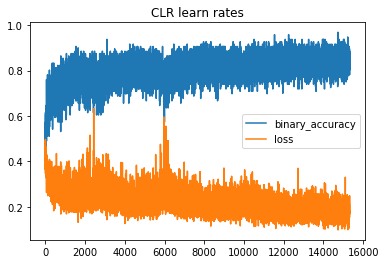

time: 304 ms


In [25]:
for metric in ['binary_accuracy', 'loss']:
    plt.plot(clr.history[metric])
plt.title('CLR learn rates')
plt.legend(['binary_accuracy', 'loss'])
plt.show() 

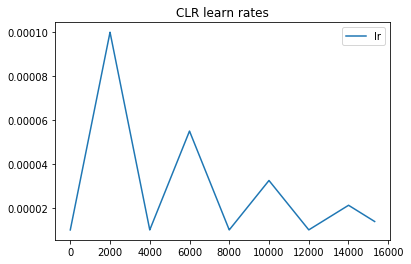

time: 184 ms


In [26]:
plt.plot(clr.history['lr'])
plt.title('CLR learn rates')
plt.legend(['lr'])
plt.show() 

INFO:utils.mura_metrics:==================================================
INFO:utils.mura_metrics:Report for elbow
INFO:utils.mura_metrics:==================================================
INFO:utils.mura_metrics:Accuracy: 0.8734177215189873
INFO:utils.mura_metrics:Kappa: 0.7293593696471394
INFO:utils.mura_metrics:Precision: 0.9791666666666666
INFO:utils.mura_metrics:Recall: 0.7121212121212122


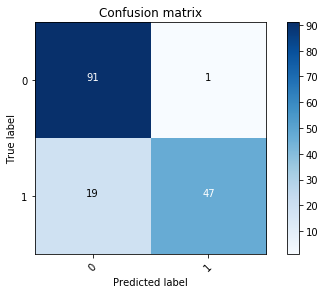

INFO:utils.mura_metrics:==================================================
INFO:utils.mura_metrics:Report for finger
INFO:utils.mura_metrics:==================================================
INFO:utils.mura_metrics:Accuracy: 0.76
INFO:utils.mura_metrics:Kappa: 0.5118225292242295
INFO:utils.mura_metrics:Precision: 0.847457627118644
INFO:utils.mura_metrics:Recall: 0.6024096385542169


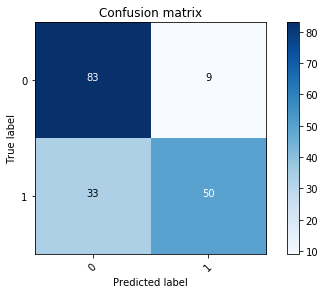

INFO:utils.mura_metrics:==================================================
INFO:utils.mura_metrics:Report for forearm
INFO:utils.mura_metrics:==================================================
INFO:utils.mura_metrics:Accuracy: 0.7819548872180451
INFO:utils.mura_metrics:Kappa: 0.5565137403702426
INFO:utils.mura_metrics:Precision: 0.972972972972973
INFO:utils.mura_metrics:Recall: 0.5625


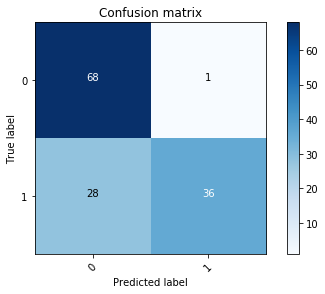

INFO:utils.mura_metrics:==================================================
INFO:utils.mura_metrics:Report for hand
INFO:utils.mura_metrics:==================================================
INFO:utils.mura_metrics:Accuracy: 0.7604790419161677
INFO:utils.mura_metrics:Kappa: 0.4622444050877476
INFO:utils.mura_metrics:Precision: 0.825
INFO:utils.mura_metrics:Recall: 0.5


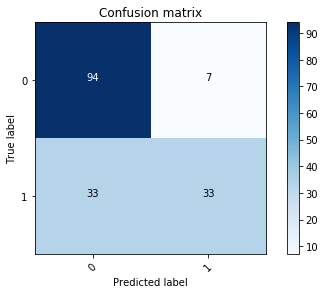

INFO:utils.mura_metrics:==================================================
INFO:utils.mura_metrics:Report for humerus
INFO:utils.mura_metrics:==================================================
INFO:utils.mura_metrics:Accuracy: 0.8444444444444444
INFO:utils.mura_metrics:Kappa: 0.6885642096012303
INFO:utils.mura_metrics:Precision: 0.896551724137931
INFO:utils.mura_metrics:Recall: 0.7761194029850746


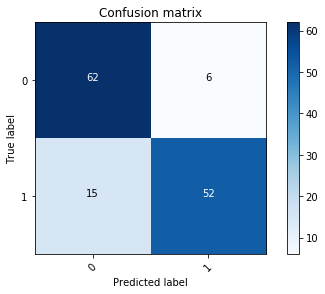

INFO:utils.mura_metrics:==================================================
INFO:utils.mura_metrics:Report for shoulder
INFO:utils.mura_metrics:==================================================
INFO:utils.mura_metrics:Accuracy: 0.7371134020618557
INFO:utils.mura_metrics:Kappa: 0.47456186935740846
INFO:utils.mura_metrics:Precision: 0.72
INFO:utils.mura_metrics:Recall: 0.7578947368421053


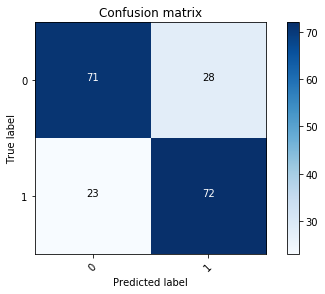

INFO:utils.mura_metrics:==================================================
INFO:utils.mura_metrics:Report for wrist
INFO:utils.mura_metrics:==================================================
INFO:utils.mura_metrics:Accuracy: 0.8438818565400844
INFO:utils.mura_metrics:Kappa: 0.6638297872340425
INFO:utils.mura_metrics:Precision: 0.9166666666666666
INFO:utils.mura_metrics:Recall: 0.6804123711340206


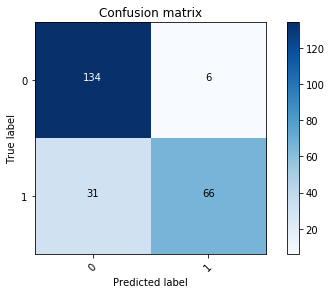

{'elbow': {'accuracy': 0.8734177215189873,
  'kappa': 0.7293593696471394,
  'precision': 0.9791666666666666,
  'recall': 0.7121212121212122},
 'finger': {'accuracy': 0.76,
  'kappa': 0.5118225292242295,
  'precision': 0.847457627118644,
  'recall': 0.6024096385542169},
 'forearm': {'accuracy': 0.7819548872180451,
  'kappa': 0.5565137403702426,
  'precision': 0.972972972972973,
  'recall': 0.5625},
 'hand': {'accuracy': 0.7604790419161677,
  'kappa': 0.4622444050877476,
  'precision': 0.825,
  'recall': 0.5},
 'humerus': {'accuracy': 0.8444444444444444,
  'kappa': 0.6885642096012303,
  'precision': 0.896551724137931,
  'recall': 0.7761194029850746},
 'shoulder': {'accuracy': 0.7371134020618557,
  'kappa': 0.47456186935740846,
  'precision': 0.72,
  'recall': 0.7578947368421053},
 'wrist': {'accuracy': 0.8438818565400844,
  'kappa': 0.6638297872340425,
  'precision': 0.9166666666666666,
  'recall': 0.6804123711340206}}

time: 994 ms


In [30]:
evaluate.report_by_body_parts()